In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import numpy as np
import math
import scipy
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
from collections import Counter

In [2]:
def lorenz(state, t, sigma, beta, rho):
    # defines Lorenz system
    
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

In [3]:
def lorenz_orbit(n,step_size,start,sigma,beta,rho):
    # n is timespan, step_size is step size in time units
    # start is a length 3 list of starting position
    # sigma, beta, rho are parameters
    # generates 3 x (n/step_size) matrix containing x, y and z realisations of Lorenz system

    p = (sigma, beta, rho)
    y0 = start
    t = np.arange(0.0, n, step_size)
    result = odeint(lorenz, y0, t, p)
    return result.T

In [4]:
def plane_linear_partition(orbit,dimension,partitions):
    # applies the k = (partitions-1) slice partition to orbit
    # orbit is a d x n matrix representing a d-dimensional trajectory
    # dimension is the integer 0 to (d-1) indicating which dimension of orbit slices are taken in
    # returns length n array symbol_sequence with symbol assignments for each point in orbit

    symbol_sequence = np.zeros(orbit.shape[1])

    for i in range(orbit.shape[1]):
        for j in range(len(partitions)-1):
            if (orbit[dimension][i] >= partitions[j]) and (orbit[dimension][i] < partitions[j+1]):
                symbol_sequence[i] = j
                break
    return symbol_sequence

In [5]:
def scatter3d(orbit, symbol_sequence, s=0.2):
    # plots orbit with assigned symbol_sequence

    cmap = plt.get_cmap('jet', np.max(symbol_sequence) - np.min(symbol_sequence) + 1)
    norm = BoundaryNorm(np.arange(np.min(symbol_sequence)-0.5, np.max(symbol_sequence)+1.5, 1), len(np.unique(symbol_sequence)))

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    scatter = ax.scatter(orbit[0],orbit[1],orbit[2], c=symbol_sequence, cmap=cmap, norm=norm, s=s)

    ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
    ax.grid(False)
    ax.axis('off')

In [6]:
def get_history_symbol_sequences(point_idxs, coarse_partition, history_length, history_delay):
    # generates a dictionary counting how many times every coarse symbol sequence history appears in the segment of orbit described by point_idxs
    # history_length and history_delay are parameters as described in paper

    output_dict = {}

    for idx in point_idxs:
        if idx >= history_length*history_delay: # only consider indexes that are far along enough in the orbit to have a sufficiently large history
            history_symbol_sequence = tuple(coarse_partition[idx-history_length*history_delay:idx:history_delay]) # get the coarse partition history
            if history_symbol_sequence not in output_dict.keys():
                output_dict[history_symbol_sequence] = 1
            else:
                output_dict[history_symbol_sequence] += 1

    return output_dict

In [7]:
def calculate_mutual_info(orbit, coarse_partition, fine_partition, history_length, history_delay):
    # calculates mutual information statistic as defined in the paper
    # orbit is d x n matrix representing trajectory
    # coarse_partition and fine_partition are length n arrays with symbol assignments for each point
    # history_length and history_delay are parameters as described in paper
    
    mutual_info = 0

    orbit_dict = get_history_symbol_sequences([i for i in range(len(orbit.T))], coarse_partition, history_length, history_delay) # dictionary with history:count for the entire orbit
    orbit_total = np.sum(list(orbit_dict.values()))

    for partition in np.unique(fine_partition):

        fine_partition_points = np.where(fine_partition == partition)[0] # indices of points that are in the specificed partition
        partition_dict = get_history_symbol_sequences(fine_partition_points, coarse_partition, history_length, history_delay) # dictionary with history:count for just this partition
        partition_total = np.sum(list(partition_dict.values()))

        # mutual info formula
        for history_symbol_sequence in partition_dict:
            p_xy = partition_dict[history_symbol_sequence]/orbit_total
            p_x = orbit_dict[history_symbol_sequence]/orbit_total
            p_y = partition_total/orbit_total
            mutual_info += p_xy * math.log2(p_xy/(p_x*p_y))

    return mutual_info

In [23]:
history_length = 5 # parameter as defined in Algorithm 1
history_delay = 10 # parameter as defined in Algorithm 1
k = 8 # number of fine partitions
dim = 0 # 0 for x slice, 1 for y slice, 2 for z slice

orbit = lorenz_orbit(100,0.01,[0.5,0.5,0.5],10,8/3,28) # d x n matrix representing trajectory
coarse_partition = plane_linear_partition(orbit,dim,np.linspace(np.min(orbit[dim]),np.max(orbit[dim]+0.001),3)) # length n array with symbol assignments for coarse partition
fine_partition = plane_linear_partition(orbit,dim,np.linspace(np.min(orbit[dim]),np.max(orbit[dim]+0.001),k+1)) # length n array with symbol assignments for fine partition

mutual_info = calculate_mutual_info(orbit, coarse_partition, fine_partition, history_length, history_delay)

In [24]:
mutual_info

0.9589951130975267

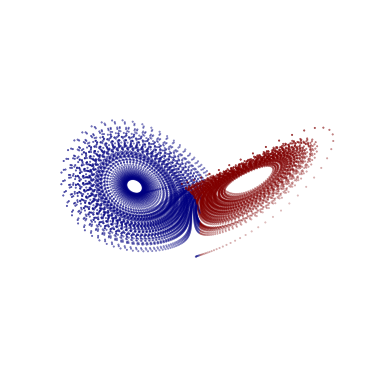

In [25]:
scatter3d(orbit,coarse_partition)

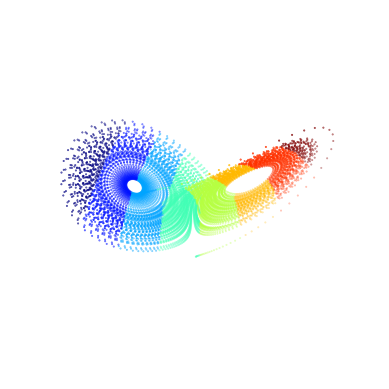

In [26]:
scatter3d(orbit,fine_partition)